In [6]:
#Class Polytope
K = QQ
PREC = 5
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy.cluster.vq import vq, kmeans, kmeans2,vq
from scipy import linalg, matrix
from copy import deepcopy as copy
data=[]

#for line in open("linux2.txt"):
    #mylist=[QQ(int(float(i)*100000)) for i in line.strip().split(",")]
    #data.append(mylist)
#data=data[:100]
#print(data)

data = [[QQ(10),QQ(10)],[QQ(10),QQ(1)],[QQ(10),QQ(2)],[QQ(10),QQ(3)],[QQ(1),QQ(5)],[QQ(3),QQ(2)]]

class Polytope:
    """
    New class of polytope. It is suppose that it is
    faster than the polytope class of sage
    """

    def __init__(self, dimension, ineq):
        """
        This is the constructor of the class Polytope.
        ineq is a list of inequalities and we distinguish between
        the homogenous and inhomogenous inequalities using the
        dimension
        """
        #print dimension, ineq
        self.dimension = dimension
        self.length = len(ineq[0])
        self.ineq = copy(ineq)
        d = dimension + 1 -self.length
        listTemp = [([K(0)] * (d) + [K(i) for i in l]) for l in ineq ]
        self.P = Polyhedron(ieqs = listTemp, base_ring = K)
        self.indexes = self.necessary(listTemp)

    def indexes(self):
        """
        This method returns a list with the indexes (with respect to
        the list of all inequalities) of the non redundant inequalities
        """
        return self.indexes

    def necessary(self, ineq):
        """
        This method returns the indexes of the
        elements which appears as inequalities in the representation
        of the polytope
        """
        return [ineq.index(l) for l in self.P.inequalities_list()]

    def interiorPoint(self):
        """
        This method calculates an interior point of the polytope
        """
        if self.P.dim()<self.dimension:
            raise Exception( "dimension of P:" + str(self.P.dim())
                             + "attribute: "+ str(self.dimension))

        problem = MixedIntegerLinearProgram(maximization = True)
        w = problem.new_variable(nonnegative=True)
        problem.set_objective(w[0])
        problem.set_max(w[0],1)
        for l in self.P.inequality_generator():
            restriction=w[0]
            l_i = (j for j in l)
            restriction=restriction + RDF(next(l_i))
            for i, k in enumerate(l_i):
                restriction -= RDF(k)*w[i + 1]
                problem.set_min(w[i + 1], None)
            problem.add_constraint(restriction<=0)
        valueProblem = problem.solve()
        solution=[]
        long = 0
        for i,v in problem.get_values(w).items():
            solution.append(v)
            long=long+1
        if long<self.dimension:
            raise Exception( "Error! empty polytope")
        return [K(element) for element in solution[1:]]


class Enumerator:
    """
    This class is an abstract class to implement, in the most possible
    general way. The notation follow the one given in the article
    'Reverse search for enumeration' by Avis and Fukuda.
    There is one sutility, though: delta is not necessary for the
    implementation BUT it is necessary to exists.
    """

    def __init__(self):
        """
        Constructor
        processes is the number of
        processes which our enumerator will launch, filename and
        directory are used for bookmarking
        """
        pass


    def f(self, v):
        """
        This function is the local search function
        Arguments:
        - `self`:
        - `v`: this is the vertex
        """
        pass

    def Adj(self, v):
        """
        This is the adjacency list oracle. It suppose to be a
        generator that returns, one by one, each of the adjacencies of v.
        Arguments:
        - `self`:
        - `v`: denotes the vertex for which we are looking the
               adjacencies
        """
        pass



    def reverse_search(self, S, heuristic = lambda x: 0, mejor_actual = infinity, coste = lambda s: infinity):
        """
        This is the main algorithm, which is a generator
        function. This means that outputs all the elements without
        keeping them in memory.
        """
        for s in S:
            yield s
            v = s
            do = True #In the original paper there was a do-while
            Adjacencies = self.Adj(v) #I suppose that it is a generator
            while do:
                b_while = True #to avoid the use of delta and j
                while b_while:
                    try:
                        #This is a minor thing, Avis and Fukuda
                        #proposed to use a distinguished element in
                        #the case there were no more adjacencies. In
                        #Python, it is customary to throw an exception
                        #which signals the end of the adjacencies
                        Next = next(Adjacencies)
                        if self.f(Next) == v and heuristic(Next) < mejor_actual:
                            mejor_actual = min(mejor_actual, coste(Next))
                            v = Next
                            Adjacencies = self.Adj(v)
                            yield v

                    except StopIteration:
                        #no more adjacencies, Avis and Fukuda would
                        #write j>= delta
                        b_while = False
                try:
                    if v == s:
                        #This is a little different because the
                        #implementation this way is simpler, but it is
                        #actually the same thing
                        v = next(Adjacencies)
                        Adjacencies = self.Adj(v)
                    else:
                        u, v = v, self.f(v)
                        Adjacencies = self.Adj(v)
                        different = u != next(Adjacencies)
                        while different:
                            different = u != next(Adjacencies)
                except StopIteration:
                    do = False

#Class Arrangement
class Arrangement(Enumerator):

    """
    This class  represents an arrangement of hyperplanes
    """

    def __init__(self, hyperplanes, pointR = []):
        """
        Constructor, which takes a list of hyperplanes, representing
        by lists of the same length and a initial point pointR.
        This point can be empty and the class generates it at random.
        """
        Enumerator.__init__(self)
        self.hyperplanes = [[i/gcd(l) for i in l] for l in hyperplanes]
        self.V = VectorSpace(K, len(hyperplanes[0]))
        if pointR:
            self.pointR = self.V(pointR)
        else:
            #Pick a first cell at
            #random, it is represented by a point
            self.pointR=self.firstPoint()

        self.initial_c = tuple( sign(self.V(L).dot_product(self.pointR))
                                for L in self.hyperplanes)
        listAux = []
        for l in self.hyperplanes:
            L=self.V(l)
            listAux.append(L*sign(L.dot_product(self.pointR)))
        self.hyperplanes = listAux


    def firstPoint(self):
        """
        This method selects a random point which does not belong in
        any of the hyperplanes
        """
        product=0
        pointR=self.V.random_element()
        while any(self.V(l).dot_product(pointR)==0
                  for l in self.hyperplanes):
            pointR=self.V.random_element()
        return pointR


    def interior_point(self,c):
        """
        Returns an interior point of the cell that have
        the signs given by c, which must be non-empty.
        """
        cell = []
        for c_i, h_i  in zip(c, self.hyperplanes):
            cell.append((c_i * h_i).list())
        p_aux =Polytope(self.V.dimension(),cell).interiorPoint()
        return self.V(p_aux)

    def f(self, v):
        """
        Returns which elements go before this element
        """
        p = self.interior_point(v)
        self.p = p
        if p == self.V(0):
            print("Empty cell!"+str(v))
            return c
        distance=infinity
        position, counter = 0, -1
        betterHyperplane=self.hyperplanes[0]/(-p.dot_product(self.hyperplanes[0]))
        for  hyperplane, c_counter in zip(self.hyperplanes, v):
            counter += 1
            dotProduct = hyperplane.dot_product(-p)
            if hyperplane.dot_product(self.pointR-p)!=0:
                auxDistance = dotProduct/hyperplane.dot_product(self.pointR-p)
            else:
                auxDistance = infinity
            if ((distance > auxDistance and 0 < auxDistance < 1 and
                 c_counter ==-1) or
                 (distance==auxDistance and
                  self.order(betterHyperplane,hyperplane/(dotProduct)))
                ):
                position, distance = counter, auxDistance
                betterHyperplane=hyperplane/(dotProduct)
        e=list(v)
        e[position]=1
        return tuple(e)

    def order(self,V,V1):
        """
        This function is returns True if V> V1, where > represents the
        lexicographic order
        """
        for v, v1 in zip(V, V1):
            if v < v1:
                 return true
            elif v> v1:
                return false
        return false

    def Adj(self, v):
        """Search for all hyperplanes that forms the faces of the polytope"""
        ineq = [(v_i* h_i).list()
                for h_i, v_i in zip(self.hyperplanes, v)]
        l = Polytope(self.V.dimension(),ineq).indexes
        for index in  l:
            yield tuple( c_i if index != j else c_i*(-1)
                    for j, c_i in enumerate(v))


#Class for generating all possible voronoi clusters when the number of clusters is two.

class Cluster2:
    """
    This class is a generator, which gives all possible clustering defined by a voronoi
    region using a tuple t, where t[i] == 1 iff p[i] belongs to cluster 1.
    """

    def __init__(self, points):
        """
        Constructor
        """
        self.points = copy(points)
        self.d = len(points[0])

    def codes(self):
        """
        This is a generator, which returns all possible clusters
        codified as a tuple t satisfying:
        t[i] == 1 iff points[i] belong to cluster 1
        """

        bound = max(max(self.points))
        points_aux = [[1] + [ 2 * i for i in l]
                      for l in self.points]
        pointR = [bound] + [0] * self.d
        ar = Arrangement(points_aux, pointR)
        for l in ar.reverse_search({tuple([1]*len(self.points))}):
            yield l

    def cost(self, s):
        return inter_cluster(self.points, [s])




#Intracluster measure
def intra_cluster(points):
    V = VectorSpace(K, len(points[0]))
    vecs = [V(p) for p in points]
    center = sum(vecs)/len(points)
    result = 0
    for v in vecs:
        result +=  (v-center).norm()**2
    return result

#Intercluster measure

def inter_cluster(data,clusters):
    '''
    return the inter cluster measure of a partition.
    clusters is a list of indicator functions, e. g.
    clusters[i] is a vector of 0 and 1's such that if
    self.data[j] in C_i iff clusters[i][j] == 1.
    To save just a litte of memory, the length of clusters is
    going to be k-1. The points in C_{k-1} are the points that are
    not in any of the other clusters. It is nice to notice that
    the mass centers are important, the intra_cluster measure
    depends heavily in the intra_cluster measure and it is not
    difficult to find examples, where the intracluster measure is
    smaller taking "fake" centroids.
    '''

    partition = []
    dist = 0
    for cluster in clusters:
        part = []
        for p, i in zip (data, cluster):
            if i>0:
                part.append(p)
        if part:
            dist += intra_cluster(part)
        part = []
        for d in zip(data,*clusters):
            if not any(i>0 for i in d[1:]):
                part.append(d[0])
        if part:
            dist += intra_cluster(part)
    return dist



In [2]:
ar = Arrangement(data)
result = []
for i in ar.reverse_search({tuple([1]*len(data))}):
    result.append(i)
print("los signos son",result)

los signos son [(1, 1, 1, 1, 1, 1), (1, 1, 1, 1, -1, 1), (1, -1, 1, 1, -1, 1), (1, -1, -1, 1, -1, 1), (1, -1, -1, -1, -1, 1), (1, -1, -1, -1, -1, -1), (-1, 1, 1, 1, 1, 1), (-1, 1, 1, 1, 1, -1), (-1, 1, 1, -1, 1, -1), (-1, 1, -1, -1, 1, -1), (-1, -1, -1, -1, 1, -1), (-1, -1, -1, -1, -1, -1)]


In [3]:
def oneDimCluster(x, y):

    """
        Candidate function to be used as a heuristic in a branch & bound
        algorithm. It is based on the projection on each of the axes,
        where the points in Y are fixed in one of the two clusters.

        INPUT: x: list of points that can be moved to the other cluster.
               y: list of points that are fixed in one of the clusters.


        OUTPUT: Optimal inter-cluster value in one dimension, where the
                points of Y are fixed.
    """

    cte = sum(y); n = len(x); m = len(y); N = n + m
    mu_1 = 0; mu_2 = (sum(x) + cte)/N
    sum_1 = 0
    sum_3 = vector([yj - mu_2 for yj in y]).norm()**2
    if n == 0:
        return sum_3
    sum_2 = vector([xj - mu_2 for xj in x]).norm()**2
    if m == 0:
        return sum_2
    c = sum_1 + sum_2 +sum_3
    #print(c)
    for i in range(1,n):
        xi = x[i - 1]; Ni = N - i; ni = n - i;
        sum_1 = sum_1 + ((i-1)/i)*(xi - mu_1)**2
        aux = mu_2*(Ni + 1) - (cte + xi)
        sum_2 = sum_2 + ((ni/(Ni**2)) - 1)*(xi - mu_2)**2 + (2/Ni)*(xi - mu_2)*(aux - ni*mu_2)
        sum_3 = sum_3 + (m/(Ni**2))*(xi - mu_2)**2 + (2/Ni)*(xi - mu_2)*(cte - m*mu_2)
        mu_1 = ((i - 1)*mu_1 + xi)/i
        mu_2 = ((Ni + 1)*mu_2 - xi)/Ni
        c = min(c, sum_1 + sum_2 +sum_3)
        #print(c)

    sum_1 = sum_1 + ((n-1)/n)*(x[n - 1] - mu_1)**2
    sum_2 = 0
    sum_3 = sum_3 + (1/m)*(x[n - 1] - mu_2)**2 + (2/m)*(x[n - 1] - mu_2)*(cte - m*mu_2)

    return min(c, sum_1 + sum_2 + sum_3)

In [4]:
def clusteringBound(Q, Lambda, S1, S2, alpha, coste, d):
    i = 1; B = 0;B_new = 0;#beta = coste, en el while beta > alpha
    while (B < alpha) and (i < d + 1):
        u = Q[:,d-i]
        X = [vector(u).dot_product(vector(s)) for s in S1]
        #print(X)
        Y = [vector(u).dot_product(vector(s)) for s in S2]
        #print(Y)
        y_min = min(Y); y_max = max(Y)
        X.sort()
        X_left = []; X_right = []; X_med = []
        for x in X:
            if x <= y_min:
                X_left.append(x)
            elif (x > y_min) and (x < y_max):
                X_med.append(x)
            else:
                X_right.append(x)
        Y.extend(X_med)
        if len(X_right)!=0 and len(X_left)!=0:
            Y_l = Y.copy(); Y_l.extend(X_left)
            Y_r = Y.copy(); Y_r.extend(X_right)
            B_new = min(oneDimCluster(list(reversed(X_right)), Y_l), oneDimCluster(X_left,Y_r))
            B = B + B_new
        elif len(X_right)!=0 and len(X_left)==0:
            Y_l = Y.copy(); Y_l.extend(X_left)
            B_new = oneDimCluster(list(reversed(X_right)), Y_l)
            B = B + B_new
        elif len(X_right)==0 and len(X_left)!=0:
            Y_r = Y.copy(); Y_r.extend(X_right)
            B_new = oneDimCluster(X_left,Y_r)
            B = B + B_new
        else:
            B_new = oneDimCluster([],Y)
            B = B + B_new
        #beta = B_new + beta - Lambda[d-i]
        i += 1
        #print(B_new)
        #print(B)
        #print(beta)
    return B

In [5]:
#Considero la partición S1 y S2 como ejemplo.
S1 = [data[i] for i in range(0,4)]
S2 = [data[i] for i in range(4,6)]
S1m = np.array(S1).T
S2m = np.array(S2).T
M = 3*np.cov(S1m) + np.cov(S2m)
vv = np.linalg.eigh(M)
#Matriz ortogonal identidad, es decir; proyectar sobre la base canónica.
Id = np.array([[1,0],[0,1]])
#Matriz ortogonal correspondiente con la base de vectores propios de la matriz M.
O = vv[1]
#Valores propios, no los uso en lo que sigue
Lambda = vv[0]

In [15]:
S1

[[10, 10], [10, 1], [10, 2], [10, 3]]

In [16]:
S2

[[1, 5], [3, 2]]

In [8]:
#Cota que nos proporciona la matriz identidad Id.
clusteringBound(Id,Lambda, S1, S2, 12, sum(Lambda), 2)

11.199999999999996

In [10]:
#Cota que nos proporciona la matriz de vectores propios de M.
clusteringBound(O,Lambda, S1, S2, 12, sum(Lambda), 2)

13.229901247041038

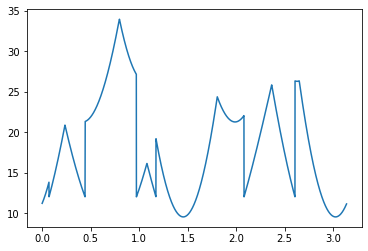

In [9]:
#Como estamos en 2 dimensiones podemos recorrer todas las matrices ortogonales y graficamos la función que surge.
x = np.arange(0, 3.14, 0.001)
y = np.array([clusteringBound(np.array([[cos(t),-sin(t)],[sin(t), cos(t)]]),Lambda, S1, S2, 12, sum(Lambda), 2) for t in x])
plt.plot(x,y)

In [11]:
#Concluimos que hay matrices ortogonales que producen cotas muchas mejores. No obstante parece díficil conseguir dicho máximo. Aunque no hay tiempo para el 10 de abril, posibles opciones son métodos Monte-Carlo, y métodos meta-heurísticos como algo estilo colonia de hormigas.
max(y)

33.92180099628191